In [37]:
# Libraries
import torch
import math
from tqdm import trange
import utils.densities as distributions
from slips.samplers.smc import *
import matplotlib.pyplot as plt

In [38]:
# Make a Pytorch device
device = torch.device('cuda')

In [39]:
# Make the target distribution
weights = torch.tensor([.1,.2,.3,.4],device=device)
means = torch.tensor([[0,0.],[0,11],[9,9],[11,0]],device=device)
variances = torch.tensor([[[1, .5],[.5,1]],[[.3, -0.2],[-0.2,.3]],[[1, .3],[.3,1]],[[1.2, -1],[-1,1.2]]],device=device)
target = distributions.MixtureDistribution(weights, [distributions.MultivariateGaussian(means[i],variances[i]) for i in range(4)])

In [40]:
# Get the score of the target distribution
def target_log_prob_and_grad(y):
    y_ = torch.autograd.Variable(y, requires_grad=True)
    log_prob_y = target.log_prob(y_).flatten()
    
    return log_prob_y, target.grad_log_prob(y) #torch.autograd.grad(log_prob_y.sum(), y_)[0].detach()

In [41]:
# Hyper-parameters
n_particles = 4096
num_noise_levels = 512
n_mcmc_steps = 64
sigma = torch.tensor(1.0)

In [42]:
# Run the SMC algorithm
samples = smc_algorithm(n_particles=n_particles,
    target_log_prob=lambda y : target.log_prob(y).flatten(),
    target_log_prob_and_grad=target_log_prob_and_grad,
    init_sample=lambda n_samples : init_sample_gaussian(n_samples, sigma, 2, device),
    init_log_prob_and_grad=lambda x : init_log_prob_and_grad_gaussian(x, sigma),                  
    betas=torch.linspace(0.0, 1.0, num_noise_levels),
    n_mcmc_steps=n_mcmc_steps,
    verbose=True
).detach().cpu()

100%|██████████| 511/511 [00:42<00:00, 12.16it/s]


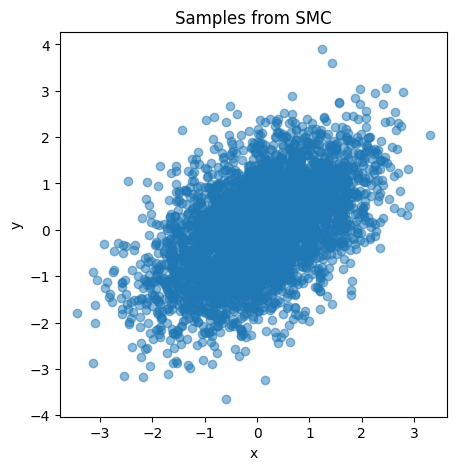

In [43]:
# Display samples
plt.figure(figsize=(5,5))
plt.scatter(samples[:,0], samples[:,1], alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Samples from SMC')
plt.show()

In [44]:
# Run the AIS algorithm
samples, weights = smc_algorithm(n_particles=n_particles,
    target_log_prob=lambda y :target.log_prob(y).flatten(),
    target_log_prob_and_grad=target_log_prob_and_grad,
    init_sample=lambda n_samples : init_sample_gaussian(n_samples, sigma, 2, device),
    init_log_prob_and_grad=lambda x : init_log_prob_and_grad_gaussian(x, sigma),                    
    betas=torch.linspace(0.0, 1.0, num_noise_levels),
    n_mcmc_steps=n_mcmc_steps,
    use_ais=True,
    verbose=True
)
samples, weights = samples.detach().cpu(), weights.detach().cpu()

100%|██████████| 511/511 [00:41<00:00, 12.28it/s]


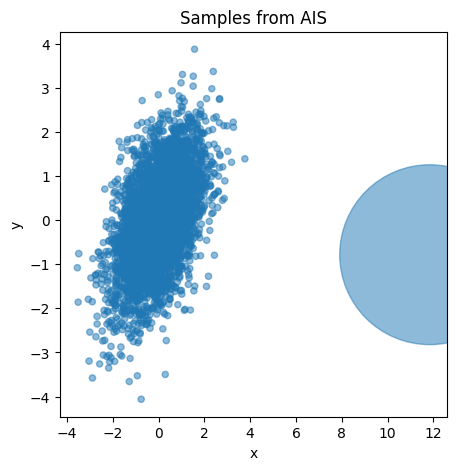

In [45]:
# Display samples
plt.figure(figsize=(5,5))
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=1e5*weights)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Samples from AIS')
plt.show()

In [46]:
# Display target samples
plt.figure(figsize=(5,5))
target_samples = target.sample((samples.shape[0],)).cpu()
plt.scatter(target_samples[:,0], target_samples[:,1], alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Samples from the target')
plt.show()

TypeError: zeros() received an invalid combination of arguments - got (tuple, int, device=torch.device, dtype=torch.dtype), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


<Figure size 500x500 with 0 Axes>